In [1]:
import torch
import os
import random
import string
from unidecode import unidecode

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"using: {device}")

using: cuda


In [2]:
class NamesDataset(torch.utils.data.Dataset):

    letter_to_int = {c: i for i, c in enumerate(string.ascii_letters[:26] + " ")}
    int_to_letter = {i: c for i, c in enumerate(string.ascii_letters[:26] + " ")}

    def __init__(self, dataset_path: str):
        xy = []
        classes = {}
        max_name_len = 0
        for i, fname in enumerate(os.listdir(dataset_path)):
            classes[i] = os.path.splitext(fname)[0]
            with open(os.path.join(dataset_path, fname), "r", encoding="utf-8") as f:
                for line in f:
                    name = unidecode(line.strip().lower())
                    name = "".join([c for c in name if c in self.letter_to_int])
                    max_name_len = max(max_name_len, len(name))
                    xy.append((name, i))

        random.seed(42)
        random.shuffle(xy)
        
        self.xy = xy
        self.classes = classes
        self.max_name_len = max_name_len

    def __getitem__(self, idx):
        x_str, y_int = self.xy[idx]
        x_str = self.padding(x_str, self.max_name_len)
        x = self.name2tensor(x_str).to(device=device)
        y = torch.zeros(len(self.classes), device=device)
        y[y_int] = 1

        return x, y
    
    def __len__(self):
        return len(self.xy)
    
    @staticmethod
    def padding(x: str, target_len):
        required_padding = target_len - len(x)
        if required_padding:
            # left_pad = random.randint(0, required_padding)
            left_pad = required_padding  # put all paddings to the left
            right_pad = required_padding - left_pad
            x_padded = left_pad * " " + x + right_pad * " "
            assert len(x_padded)==target_len, "padding has gone wrong!"
            return x_padded
        else:
            return x

    @staticmethod
    def name2tensor(name):
        tensor = torch.zeros(len(name), len(NamesDataset.letter_to_int))
        for i, char in enumerate(name):
            if char not in NamesDataset.letter_to_int:
                raise ValueError("'{char}' does not exist in letter_to_int dictionary.")
            tensor[i, NamesDataset.letter_to_int[char]] = 1.0
        return tensor
    
    @staticmethod
    def tensor2name(tensor):
        name = ""
        for row in tensor:
            name += NamesDataset.int_to_letter[row.argmax(-1).item()]
        return name

ds = NamesDataset(dataset_path="../datasets/names-3class/")
ds_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=False)

In [3]:
class NameEncoder(torch.nn.Module):
    def __init__(self, seq_len, feat_len, latent_dim):
        super().__init__()
        self.seq_len = seq_len
        self.feat_len = feat_len
        self.hidden_size = 64
        self.num_layers = 64

        self.layer1 = torch.nn.RNN(feat_len, self.hidden_size, self.num_layers, batch_first=True)
        self.layer2 = torch.nn.Linear(self.hidden_size*self.seq_len, self.hidden_size)
        self.layer3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.layer4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.mu_layer = torch.nn.Linear(self.hidden_size, latent_dim)
        self.sigma_layer = torch.nn.Linear(self.hidden_size, latent_dim)

    def forward(self, X):
        hidden1 = torch.zeros(self.num_layers, X.shape[0], self.hidden_size, device=device)
        out, _= self.layer1(X, hidden1)

        out = torch.flatten(out, start_dim=1)
        out = self.layer2(out)
        out = torch.relu(out)

        out = self.layer3(out)
        out = torch.relu(out)

        out = self.layer4(out)
        out = torch.relu(out)

        mu = self.mu_layer(out)
        sigma = self.sigma_layer(out)

        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return mu, sigma, z

class NameDecoder(torch.nn.Module):
    def __init__(self, seq_len, feat_len, latent_dim):
        super().__init__()
        self.seq_len = seq_len
        self.feat_len = feat_len
        self.hidden_size = 64
        self.num_layers = 64

        self.layer1 = torch.nn.Linear(latent_dim, self.hidden_size)
        self.layer2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.layer3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.layer4 = torch.nn.Linear(self.hidden_size, self.hidden_size*self.seq_len)
        self.layer5 = torch.nn.RNN(self.hidden_size, self.feat_len, self.num_layers, batch_first=True)
        self.final_layer = torch.nn.Sigmoid()

    def forward(self, X):
        out = self.layer1(X)
        out = torch.relu(out)

        out = self.layer2(out)
        out = torch.relu(out)

        out = self.layer3(out)
        out = torch.relu(out)

        out = self.layer4(out)
        out = torch.relu(out)
        out = out.view(X.shape[0], self.seq_len, self.hidden_size)

        hidden = torch.zeros(self.num_layers, X.shape[0], self.feat_len, device=device)
        out, _ = self.layer5(out, hidden)

        out = self.final_layer(out)
        
        return out

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        mu, sigma, z = self.encoder(X)
        reconstructed_X = self.decoder(z)
        return reconstructed_X, mu, sigma

In [4]:
en = NameEncoder(14, 27, 2).to(device)
de = NameDecoder(14, 27, 2).to(device)
vae = VAE(en, de)

In [5]:
x, y = next(iter(ds_loader))
with torch.no_grad():
    print("input: ", x.shape)
    mu, sigma, z = en(x)
    print("encoder mu: ", mu.shape)
    print("encoder sigma: ", sigma.shape)
    print("encoder z: ", z.shape)
    print("decoded: ", de(z).shape)

input:  torch.Size([128, 14, 27])
encoder mu:  torch.Size([128, 2])
encoder sigma:  torch.Size([128, 2])
encoder z:  torch.Size([128, 2])
decoded:  torch.Size([128, 14, 27])


In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)

def lossfn(reconstructed_x, x, mu, sigma):
    BCE = torch.nn.CrossEntropyLoss()(reconstructed_x, x)
    KLD = -5e-1 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    return BCE + KLD
    # return BCE

def train_one_batch(X):
    """
    do one step training.
    Args:
        X (Tensor): input tensors.

    Returns:
        float: loss value.
    """
    optimizer.zero_grad()
    reconstructed_X, mu, sigma = vae(X)
    loss = lossfn(reconstructed_X, X, mu, sigma)
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
n_epochs = 10
print("epoch\t\tbatch\t\ttraining loss")
print("----------------------------------------------")
train_loss = []
for epoch in range(n_epochs):
    train_loss.append(0)
    ibatch = 0
    all_batches = len(ds_loader)
    for X, Y in ds_loader:
        ibatch += 1
        train_loss[-1] += train_one_batch(X)
        print(f"{epoch+1}\t\t{ibatch}/{all_batches}\t\t{train_loss[-1]/all_batches:.5f}", end="\r")
    print()

epoch		batch		training loss
----------------------------------------------
1		53/53		1.44916
2		53/53		1.28534
3		53/53		1.28337
4		53/53		1.28313
5		53/53		1.28307
6		53/53		1.28304
7		53/53		1.28332
8		53/53		1.28300
9		53/53		1.28296
10		53/53		1.28294


In [8]:
import pandas as pd
x, y = next(iter(ds_loader))
with torch.no_grad():
    output, _, _ = vae(x)
df = {"input":[], "output":[]}
for i in range(20):
    x_str = ds.tensor2name(x[i, ...])
    output_str = ds.tensor2name(output[i, ...])
    df["input"].append(x_str.strip())
    df["output"].append(output_str.strip())

df = pd.DataFrame(df)
df = df.style.set_properties(**{'text-align': 'center'})
df


,input,output
0,kitamura,cjiiiii
1,epsom,cjiiiii
2,hadad,cjiiiii
3,kouri,cjiiiii
4,manson,cjiiiii
5,nowell,cjiiiii
6,rosenblatt,cjiiiii
7,nanson,cjiiiii
8,kassab,cjiiiii
9,meakin,cjiiiii


In [9]:
Z = []
Y = []
with torch.no_grad():
    for x, y in ds_loader:
        Z.append(en(x)[2])
        Y.append(y.argmax(-1))
Z = torch.concat(Z, dim=0).to("cpu").numpy()
Y = torch.concat(Y, dim=0).to("cpu").numpy()        

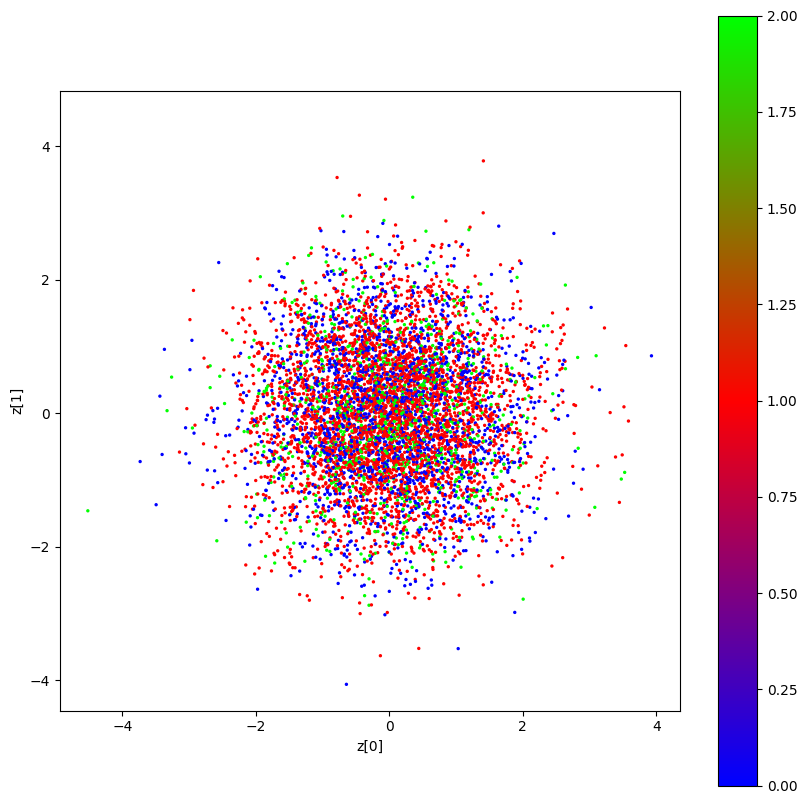

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

s = axs.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='brg', s=2)
axs.set_xlabel('z[0]')
axs.set_ylabel('z[1]')
plt.colorbar(s)
axs.axis('square')

plt.show()